In [1]:
import random

import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession

from replay.session_handler import State
from simulator.utils import pandas_to_spark

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'

spark = SparkSession.builder\
    .appName('simulator')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '4g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

np.random.seed(1234)

users_df = pd.DataFrame(data=np.random.normal(1, 1, size=(10000, 35)), columns=[f'user_attr_{i}' for i in range(35)]) 
items_df = pd.DataFrame(data=np.random.normal(-1, 1, size=(2000, 35)), columns=[f'item_attr_{i}' for i in range(35)]) 
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df['user_id'] = np.arange(len(users_df))
items_df['item_id'] = np.arange(len(items_df))
history_df_all = pd.DataFrame()
history_df_all['user_id'] = np.random.randint(0, 10000, size=33000)
history_df_all['item_id'] = np.random.randint(0, 2000, size=33000)
history_df_all['relevance'] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
history_df_all['relevance'] = np.where(dot >= 0.5, 1, 0)
history_df_all = history_df_all.drop_duplicates(subset=['user_id', 'item_id'], ignore_index=True)

history_df_train = history_df_all.iloc[:30000]
history_df_val = history_df_all.iloc[30000:]

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)

/data/home/anthony/.conda/envs/simulator_test1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/11/29 10:02:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/29 10:02:48 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Divide users into strats

In [2]:
import pyspark.sql.functions as sf


## Divide users by half for demostration purposes
users_cluster_1_df = users_df.filter(sf.col('user_id') < 5000)
users_cluster_2_df = users_df.filter(sf.col('user_id') >= 5000)

## Обучение генераторов

In [3]:
import warnings
warnings.filterwarnings("ignore")

from simulator.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
from simulator.modules import evaluate_synthetic

generator_1 = SDVDataGenerator(
    label='synth_strat_1',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)
generator_2 = SDVDataGenerator(
    label='synth_strat_2',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)

generator_1.fit(users_cluster_1_df.drop('user_id'))
generator_2.fit(users_cluster_2_df.drop('user_id'))
items_generator.fit(items_df)

for g, d in zip([generator_1, generator_2], [users_cluster_1_df, users_cluster_2_df]):
    print(g.getLabel(), evaluate_synthetic(g.generate(d.count()).drop('user_id'), d.drop('user_id')))

users_com_generator = CompositeGenerator(
    generators=[generator_1, generator_2],
    label='users_composite',
    weights=[0.5, 0.5]
)
users_com_generator.generate(10000)

22/11/29 10:02:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


synth_strat_1 {'LogisticDetection': 1.0, 'SVCDetection': 0.89126399718994, 'KSTest': 0.9855257142857143, 'ContinuousKLDivergence': 0.9671574151768041}


synth_strat_2 {'LogisticDetection': 1.0, 'SVCDetection': 0.8700744876708597, 'KSTest': 0.9846000000000001, 'ContinuousKLDivergence': 0.9670461996009401}


## Simulator initialization

In [4]:
from simulator.modules import Simulator

sim = Simulator(
    user_gen=users_com_generator,
    item_gen=items_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark
)

## Response function

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import PipelineModel
from simulator.response import CosineSimilatiry, BernoulliResponse, NoiseResponse, ParametricResponseFunction


va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="cosine_proba"
)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='noise_proba', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['cosine_proba', 'noise_proba'],
    outputCol='proba',
    weights=[1.0, 0.0]
)
br = BernoulliResponse(inputCol='proba', outputCol='response')

cos_sim_model = PipelineModel(
    stages=[
        va_users,
        va_items,
        cos_sim,
        noise_resp,
        resp_func,
        br
    ]
)

In [6]:
from simulator.modules import EvaluateMetrics

test_df = history_df_train.join(users_df, 'user_id', 'left')\
                          .join(items_df, 'item_id', 'left')

lr_eval = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='proba',
    labelCol='relevance',
    mllib_metrics=['areaUnderROC', 'areaUnderPR']
)
lr_eval(cos_sim_model.transform(test_df))

{'areaUnderROC': 0.999999608882207, 'areaUnderPR': 0.9999995524577757}

## Recommendation algorithm training

In [7]:
from replay.data_preparator import Indexer

indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_com_generator.sample(1.0), items=items_df)

from replay.models import UCB

model = UCB(sample=True)
model.fit(log=indexer.transform(history_df_train.limit(1)))

22/11/29 10:05:41 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
22/11/29 10:05:41 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
22/11/29 10:05:42 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.
22/11/29 10:05:42 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


In [8]:
from simulator.modules import EvaluateMetrics
from replay.metrics import NDCG, Precision, Recall

evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

spark.sparkContext.setLogLevel('ERROR')

In [9]:
import time
from replay.utils import get_top_k_recs

metrics = []
for i in range(50):
    iter_time = time.time()
    ## sample a bunch of users
    users = sim.sample_users(0.02).cache()

    log = sim.get_log(users)
    if log is None:
        log = history_df_train.limit(1)
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items_df)
    )
    recs = indexer.inverse_transform(recs).cache()

    ## simulate responses on recommended items
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    ## update log with simulated responses
    sim.update_log(true_resp, iteration=i)

    ## calculate metrics
    metrics.append(evaluator(true_resp))

    ## refit recommendation model
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    # pairs.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

Iteration 0 finished in 19.233423709869385 sec.
Iteration 1 finished in 13.708597183227539 sec.


Iteration 2 finished in 13.541823387145996 sec.
Iteration 3 finished in 13.027352333068848 sec.
Iteration 4 finished in 13.25719690322876 sec.
Iteration 5 finished in 12.813174724578857 sec.
Iteration 6 finished in 12.585135459899902 sec.
Iteration 7 finished in 13.16139554977417 sec.
Iteration 8 finished in 12.964518308639526 sec.
Iteration 9 finished in 12.951754331588745 sec.
Iteration 10 finished in 12.88650894165039 sec.
Iteration 11 finished in 13.925736665725708 sec.
Iteration 12 finished in 13.095169305801392 sec.
Iteration 13 finished in 13.09789752960205 sec.


Iteration 14 finished in 13.032402992248535 sec.
Iteration 15 finished in 13.328567266464233 sec.
Iteration 16 finished in 13.74241590499878 sec.
Iteration 17 finished in 12.921535730361938 sec.
Iteration 18 finished in 13.43843698501587 sec.
Iteration 19 finished in 13.230594635009766 sec.
Iteration 20 finished in 13.373889923095703 sec.
Iteration 21 finished in 13.79914402961731 sec.
Iteration 22 finished in 13.900254249572754 sec.
Iteration 23 finished in 13.193178415298462 sec.
Iteration 24 finished in 14.096498727798462 sec.
Iteration 25 finished in 13.41923189163208 sec.
Iteration 26 finished in 13.120378971099854 sec.
Iteration 27 finished in 13.450253009796143 sec.
Iteration 28 finished in 13.461100816726685 sec.
Iteration 29 finished in 13.556114435195923 sec.
Iteration 30 finished in 13.225887537002563 sec.


Iteration 31 finished in 13.572283744812012 sec.
Iteration 32 finished in 13.09179425239563 sec.
Iteration 33 finished in 13.53775954246521 sec.
Iteration 34 finished in 14.19674277305603 sec.
Iteration 35 finished in 14.423258304595947 sec.


Iteration 36 finished in 14.58193302154541 sec.


Iteration 37 finished in 14.039785385131836 sec.


Iteration 38 finished in 14.425009727478027 sec.


Iteration 39 finished in 14.091775178909302 sec.


Iteration 40 finished in 14.726505279541016 sec.


Iteration 41 finished in 13.792420148849487 sec.


Iteration 42 finished in 14.807380676269531 sec.


Iteration 43 finished in 14.74394941329956 sec.


Iteration 44 finished in 14.335069417953491 sec.


Iteration 45 finished in 14.576973915100098 sec.


Iteration 46 finished in 14.938384771347046 sec.


Iteration 47 finished in 14.849287033081055 sec.


Iteration 48 finished in 15.013909816741943 sec.


Iteration 49 finished in 14.30401086807251 sec.


(0.6, 1.01)

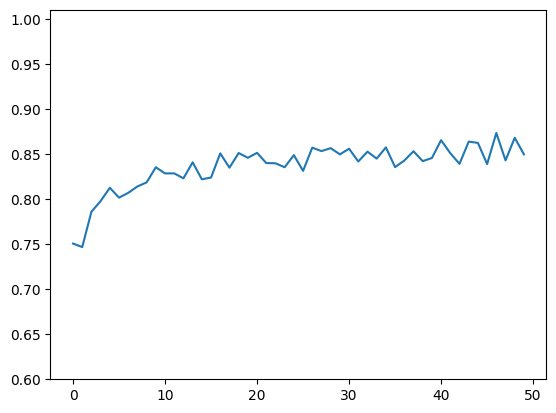

In [10]:
metrics_pdf = pd.DataFrame(metrics)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(metrics_pdf['NDCG@10'])
plt.ylim(0.6, 1.01)